<a href="https://colab.research.google.com/github/albisbub/RFIC-Pitches/blob/master/_notebooks/2020-04-29-ALK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFIC MEETING 7
> Alaska Airlines Buy Pitch

- toc:true
- branch: master
- badges: true
- comments: true
- author: Blaise and Abby
- permalink: /ALK/
- categories: [fastpages, jupyter]

In [142]:
#hide
#Requirements:
import warnings
warnings.filterwarnings('ignore')
!pip install requests bs4 pandas yahoofinancials yahoo_fin requests_html
!pip install argparse
!pip install matplotlib urllib3 seaborn
!pip install fuckit

In [0]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from datetime import timedelta, datetime, date
%config InlineBackend.figure_format = 'retina'

chart_width = 550
chart_height= 400

import gspread
from oauth2client.service_account import ServiceAccountCredentials

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests
# !pip install 
from bs4 import BeautifulSoup
import pandas as pd
from yahoofinancials import YahooFinancials
from yahoo_fin.stock_info import get_quote_table, get_stats, get_live_price, get_income_statement, get_balance_sheet, get_cash_flow
# !pip install dict
# from dict import dict
def getQuote(ticker):
    return str(round(get_live_price(ticker), 2))

def finviz_summaryTable(symbols):
    # Get Column Header
    req = requests.get("https://finviz.com/quote.ashx?t=FB")
    soup = BeautifulSoup(req.content, 'html.parser')
    table = soup.find_all(lambda tag: tag.name=='table')
    rows = table[8].findAll(lambda tag: tag.name=='tr')
    out=[]
    for i in range(len(rows)):
        td=rows[i].find_all('td')
        out=out+[x.text for x in td]

    ls=['Ticker','Sector','Sub-Sector','Country']+out[::2]

    dict_ls={k:ls[k] for k in range(len(ls))}
    df=pd.DataFrame()
    print('Fetching Data...')
    for j in range(len(symbols)):

      try:

        req = requests.get("https://finviz.com/quote.ashx?t="+symbols[j])
        if req.status_code !=200:
            continue
        soup = BeautifulSoup(req.content, 'html.parser')
        table = soup.find_all(lambda tag: tag.name=='table')
        rows=table[6].findAll(lambda tag: tag.name=='tr')
        sector=[]
        for i in range(len(rows)):
            td=rows[i].find_all('td')
            sector=sector+[x.text for x in td]
        sector=sector[2].split('|')
        rows = table[8].findAll(lambda tag: tag.name=='tr')
        out=[]
        for i in range(len(rows)):
            td=rows[i].find_all('td')
            out=out+[x.text for x in td]
        out=[symbols[j]]+sector+out[1::2]
        out_df=pd.DataFrame(out).transpose()
        df=df.append(out_df,ignore_index=True)
        print('Done!')
        
        df=df.rename(columns=dict_ls)   

      except BaseException as E:
        print("Could not find data:", E)

    return(df)
    
def yf_summaryTable(tickerList):
    values = []
    for i in tickerList:
      try:
        value = get_quote_table(i , dict_result = True)
        values.append(value)
      except BaseException as e:
        print(e)
             
    outD = dict(zip(tickerList,values))
            
    return outD
        
def yf_stats_compTable(tickerList):
    values = []
    for i in tickerList:
      try:
        value = get_stats(i)
        values.append(value)
      except BaseException as e:
        print(e)
             
    outD= dict(zip(tickerList,values))
            
    return outD
               
def get_prices(tickerlist, start, end, period):
    yahoo_financials = YahooFinancials(tickerlist)
    jsonDATA = yahoo_financials.get_historical_price_data(start,end, period)
    return jsonDATA

In [0]:
#hide
def make_multi_LineGraph(data, logged):
  try:  
    df = data
    if logged == True:
      df['log Value'] =  np.around(np.log(df.Value), 4)
      aY = ('log Value:Q')
      scc = alt.Scale(type='log')
      color1 = alt.Color('Metric:N', legend=alt.Legend(title="Natural Log of Metrics", labelFontSize=15, titleFontSize=17),
                      scale=alt.Scale(scheme='tableau20'))
    else:
      aY = ('Value:Q')
      scc=alt.Scale(type='linear')
      color1 = alt.Color('Metric:N', legend=alt.Legend(title="Metrics",labelFontSize=15, titleFontSize=17),
                      scale=alt.Scale(scheme='tableau20'))   
    label = alt.selection_multi(fields=['Metric'], bind='legend', 
        on='mouseover',  # select on mouseover events
        nearest=True,    # select data point nearest the cursor
        empty='none'     # empty selection includes no data points
    )
    # define our base line chart of stock prices
    base = alt.Chart().mark_line().encode(
        alt.X('Year:T'),
        alt.Y(aY, scale=scc) ,
        color = color1 
        
        
        # alt.Color(' Metric:N'), opacity = alt.condition(label, alt.value(1), alt.value(0.5))

    )

    graph = alt.layer(
        base, # base line chart
        
        # add a rule mark to serve as a guide line
        alt.Chart().mark_rule(color='#aaa').encode(
            x='Year:T'
        ).transform_filter(label),
        
        # add circle marks for selected time points, hide unselected points
        base.mark_circle().encode(
            opacity=alt.condition(label, alt.value(1), alt.value(0))
        ).add_selection(label),

        # add white stroked text to provide a legible background for labels
        base.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
            text=aY
        ).transform_filter(label),

        # add text labels for stock prices
        base.mark_text(align='left', dx=5, dy=-5).encode(
            text=aY
        ).transform_filter(label),
        
        data=df
    ).properties(
        width=700,
        height=400
    )
    
    return graph
  except BaseException as e:
    pass


def formatPeers(inputs):
  ColumnList = list(inputs.columns)
  yearList = list(inputs.Ticker)

  print(ColumnList)
  print(yearList)


  transposed = inputs.transpose()
  cleaned = transposed.reset_index()

  new_header = cleaned.iloc[0] #grab the first row for the header
  cleaned = cleaned[1:] #take the data less the header row
  cleaned.columns = new_header #set the header row as the df header

  byYear = cleaned.set_index("Ticker").stack()

  df = pd.DataFrame(byYear, columns=['Value'])
  df.reset_index(inplace=True)
  print(df.columns)
  df.rename(columns={0:'Ticker'}, inplace=True)
  df.dropna(inplace=True)
  df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

  new_header = df.iloc[0] #grab the first row for the header
  df = df[1:] #take the data less the header row
  df.columns = new_header #set the header row as the df header


  return df

def get_financials(tickerList):
  """
  list of lists
  same order as ticker list
  each list contains a list of datframes in the order income statement , balance sheet, cash flow
  """

  tickersDF = []
  for i in tickerList:

    income_statement = get_income_statement(i)
    
    balance_sheet = get_balance_sheet(i)
    
    cash_flow = get_cash_flow(i)

    finList = [income_statement, balance_sheet, cash_flow]
    tickersDF.append(finList)

  return tickersDF

def interactive_bat(data):


  source = data
  brush = alt.selection(type='interval', encodings=['x'])

  bars = alt.Chart().mark_bar().encode(
      x='Ticker:N',
      y='mean(Value):Q',
      opacity=alt.condition(brush, alt.OpacityValue(1), alt.OpacityValue(0.7)),
  ).add_selection(
      brush
  )

  line = alt.Chart().mark_rule(color='firebrick').encode(
      y='mean(Value):Q',
      size=alt.SizeValue(3)
  ).transform_filter(
      brush
  )

  graph = alt.layer(bars, line, data=source)

  return graph

  

In [0]:
#hide
subjectCompany = "ALK"
peers = ["AAL", "DAL", 'LUV', 'UAL']
tickerList = []
tickerList.append(subjectCompany)
for i in peers:

  tickerList.append(i)

In [0]:
#hide
all_financials_querry = get_financials(tickerList)
#Works
subjectTfinancials = all_financials_querry[0]

In [147]:
#hide
## Clean some shit up for charting
from datetime import date
today = date.today()

now = str(today.strftime("%m/%d/%Y"))
print(now)

for i in subjectTfinancials:
  a = i
  a.rename({'ttm': now}, inplace=True, axis = "columns")
  a.rename({'Breakdown': "Year"}, inplace=True, axis = "columns")


04/30/2020


In [148]:
#hide
!pip install pyfinmod
from pyfinmod.financials import Financials
parser = Financials(subjectCompany)

# (parser.cash_flow_statement)
# (parser.balance_sheet_statement)
# (parser.income_statement)


cash = (parser.cash_flow_statement).transpose().reset_index().rename(columns={'index':'Year'})
balance = (parser.balance_sheet_statement).transpose().reset_index().rename(columns={'index':'Year'})
income = (parser.income_statement).transpose().reset_index().rename(columns={'index':'Year'})# income = subjectTfinancials[0]

# income = subjectTfinancials[0]
# balance = subjectTfinancials[1]
# cash = subjectTfinancials[2]

# Subjet Company Financials

## Income Statement

In [149]:
#hide-input
income
## LONG FORMATED FINANCIALS (Year in columns)


row name,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin
0,2019-12-31,8.781000e+09,0.062561,0.000000e+00,8.781000e+09,0.0,2.370000e+09,7.718000e+09,1.063000e+09,78000000.0,1.016000e+09,247000000.0,0.0,0.0,7.690000e+08,0.0,7.690000e+08,6.240,6.19,123279000.0,124289000.0,1.391917,1.000000,0.169229,0.121057,0.087575,0.116843,1.486000e+09,1.063000e+09,7.690000e+08,0.115704,0.087575
1,2018-12-31,8.264000e+09,0.041724,0.000000e+00,8.264000e+09,0.0,2.190000e+09,7.621000e+09,6.430000e+08,91000000.0,5.850000e+08,148000000.0,0.0,0.0,4.370000e+08,0.0,4.370000e+08,3.550,3.52,123230000.0,123975000.0,1.274450,1.000000,0.125968,0.077807,0.052880,0.028437,1.041000e+09,6.430000e+08,4.370000e+08,0.070789,0.052880
2,2017-12-31,7.933000e+09,0.337548,1.950000e+08,7.738000e+09,0.0,1.924000e+09,6.673000e+09,1.260000e+09,103000000.0,1.207000e+09,173000000.0,0.0,0.0,1.034000e+09,0.0,1.034000e+09,8.390,8.35,123211000.0,123854000.0,1.194955,0.975419,0.205723,0.158830,0.130342,0.071095,1.632000e+09,1.260000e+09,1.034000e+09,0.152149,0.130342
3,2016-12-31,5.931000e+09,0.059486,1.260000e+08,5.805000e+09,0.0,1.382000e+09,4.582000e+09,1.349000e+09,55000000.0,1.345000e+09,531000000.0,0.0,0.0,8.140000e+08,0.0,8.140000e+08,6.590,6.54,123557000.0,124389000.0,1.093344,0.978756,0.288653,0.227449,0.137245,0.119373,1.712000e+09,1.349000e+09,8.140000e+08,0.226775,0.137245
4,2015-12-31,5.598000e+09,0.042846,1.130000e+08,5.485000e+09,0.0,1.254000e+09,4.300000e+09,1.298000e+09,42000000.0,1.312000e+09,464000000.0,0.0,0.0,8.480000e+08,0.0,8.480000e+08,6.610,6.56,128373000.0,129372000.0,0.788424,0.979814,0.289032,0.231869,0.151483,0.134512,1.618000e+09,1.298000e+09,8.480000e+08,0.234369,0.151483
5,2014-12-31,5.368000e+09,0.041117,9.300000e+07,5.275000e+09,0.0,1.136000e+09,4.406000e+09,9.620000e+08,48000000.0,9.750000e+08,370000000.0,0.0,0.0,6.050000e+08,0.0,6.050000e+08,4.470,4.42,135445000.0,136801000.0,0.497072,0.982675,0.233979,0.179210,0.112705,0.062593,1.256000e+09,9.620000e+08,6.050000e+08,0.181632,0.112705
6,2013-12-31,5.156000e+09,0.107151,8.400000e+07,5.072000e+09,0.0,1.086000e+09,4.318000e+09,8.380000e+08,56000000.0,8.160000e+08,308000000.0,0.0,0.0,5.080000e+08,0.0,5.080000e+08,7.260,7.16,69955000.0,70939000.0,0.394705,0.983708,0.214895,0.162529,0.098526,0.080489,1.108000e+09,8.380000e+08,5.080000e+08,0.000000,0.098526
7,2012-12-31,4.657000e+09,0.078559,7.900000e+07,4.578000e+09,0.0,1.038000e+09,4.125000e+09,5.320000e+08,64000000.0,5.140000e+08,198000000.0,0.0,0.0,3.160000e+08,0.0,3.160000e+08,4.470,4.40,70708000.0,71784000.0,0.000000,0.983036,0.170925,0.114237,0.067855,0.050462,7.960000e+08,5.320000e+08,3.160000e+08,0.110371,0.067855
8,2011-12-31,4.317800e+09,0.126686,6.720000e+07,4.250600e+09,0.0,9.905000e+08,3.868900e+09,4.489000e+08,87300000.0,3.937000e+08,149200000.0,0.0,0.0,2.445000e+08,0.0,2.445000e+08,6.810,6.66,35878000.0,36710000.0,0.000000,0.984437,0.161147,0.103965,0.056626,0.071472,6.958000e+08,4.489000e+08,2.445000e+08,0.091181,0.056626
9,2010-12-31,3.832300e+09,0.127213,5.750000e+07,3.774800e+09,0.0,0.000000e+00,3.360700e+09,4.716000e+08,108300000.0,4.059000e+08,154800000.0,0.0,0.0,2.511000e+08,0.0,2.511000e+08,7.010,6.83,35822000.0,36786000.0,0.000000,0.984996,0.183206,0.123059,0.065522,0.096730,7.021000e+08,4.716000e+08,2.511000e+08,0.105916,0.065522


In [0]:
#hide
## WIDE FORMATTED FINANCIALS (Metric In Columns)

# def formatStmnt(inputs):
#   ColumnList = list(inputs.columns)
#   yearList = list(inputs.Year)

#   print(ColumnList)
#   print(yearList)


#   transposed = inputs.transpose()
#   cleaned = transposed.reset_index()

#   new_header = cleaned.iloc[0] #grab the first row for the header
#   cleaned = cleaned[1:] #take the data less the header row
#   cleaned.columns = new_header #set the header row as the df header

#   byYear = cleaned.set_index("Year").stack()

#   df = pd.DataFrame(byYear, columns=['Value'])
#   df.reset_index(inplace=True)
#   print(df.columns)
#   df.rename(columns={0:'Metric'}, inplace=True)
#   df.dropna(inplace=True)
#   df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
#   df = inputs



#   return df


def formatStmnt(inputs):
  ColumnList = list(inputs.columns)
  yearList = list(inputs.Year)

  # print(ColumnList)
  # print(yearList)


  # transposed = inputs.transpose()
  cleaned = inputs.rename_axis('Metric')
  # print(cleaned.columns)
  # cleaned.drop(cleaned.columns[0],inplace=True)
  byYear = cleaned.set_index('Year').stack()

  df = pd.DataFrame(byYear, columns=['Value'])
  df.reset_index(inplace=True)
  # print(df.columns)
  df.rename(columns={'row name':'Metric'}, inplace=True)
  # df.dropna(inplace=True)
  # df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
  # print(df)


  # print(df.columns)
  df = df[~df['Metric'].isin(['level_0','index'])]
  # df = df.drop(['level_0','index'],axis=0)
  # print(df.Year)

  df.Year = df.Year.astype(str)
  return df

In [0]:
#hide
#stack the transposed dataframes.
df = formatStmnt(income)
metricList = df[df.columns[1]].unique()

In [0]:
#hide
####PICK METRICS


columnList = [


"Revenue"  , 
"Cost of Revenue"  , 
"Gross Profit"  , 



"R&D Expenses"  , 
"SG&A Expense"  , 
"Operating Expenses"  , 
"Operating Income"  , 
"Interest Expense"  , 



"Earnings before Tax"  , 
"Income Tax Expense"  , 

"Net Income - Non-Controlling int"  , 
"Net Income - Discontinued ops"  , 
"Net Income"  , 

"Preferred Dividends"  , 
"Net Income Com"  , 

"EPS"  , 
"EPS Diluted"  , 
"Dividend per Share"  , 

"Weighted Average Shs Out"  , 


"Weighted Average Shs Out (Dil)"  , 





"Gross Margin"  , 
"EBITDA Margin"  , 
"EBIT Margin"  , 
"Profit Margin"  , 
"Free Cash Flow margin"  , 
"EBITDA"  , 
"EBIT"  , 


"Consolidated Income"  , 
"Earnings Before Tax Margin"  , 
"Net Profit Margin"  , 

"Revenue Growth"  , 

]

revenueBases = ['Revenue','Gross Profit', "Operating Income" ,"Earnings before Tax" , "Net Income", "Net Income Com","Consolidated Income" ,"EBITDA" ,"EBIT" ]
revg = ["Revenue Growth"]
epsS = ["EPS"  , 
"EPS Diluted"  , 
"Dividend per Share"  ,]
costs = [  "Cost of Revenue"  ,"Operating Expenses" ,'Interest Expense', 'Income Tax Expense', "Preferred Dividends"  , ]

oppCosts = ["R&D Expenses"  , 
"SG&A Expense"  , ]

floats = ["Weighted Average Shs Out"  , 


"Weighted Average Shs Out (Dil)"  , 
]
margins = [
"Gross Margin"  , 
"EBITDA Margin"  , 
"EBIT Margin"  , 
"Profit Margin"  , 
"Free Cash Flow margin"  , 
"Earnings Before Tax Margin"  , 
"Net Profit Margin"  , 
]

growthRates = ["Revenue Growth"]

revs_g = df[df['Metric'].isin(revenueBases)]
eps_g = df[df['Metric'].isin(epsS)]
cost_g = df[df['Metric'].isin(costs)]
operating_g = df[df['Metric'].isin(oppCosts)]
float_g = df[df['Metric'].isin(floats)]
margins_g = df[df['Metric'].isin(margins)]

revs_gg = df[df['Metric'].isin(growthRates)]



In [0]:
#hide
most_recent_float = list((float_g.Value).dropna())[0]

### Revenues

In [154]:
#hide-input


make_multi_LineGraph(revs_g, False)


alt.LayerChart(...)

### Revenue Growth & Change in Growth

In [155]:
#hide-input
make_multi_LineGraph(revs_gg, False)


alt.LayerChart(...)

In [156]:
#hide-input

make_multi_LineGraph(revs_gg, True)


alt.LayerChart(...)

### EPS

In [157]:
#hide-input

make_multi_LineGraph(eps_g, False)



alt.LayerChart(...)

### Cost Components

In [158]:
#hide-input

make_multi_LineGraph(cost_g, False)


alt.LayerChart(...)

In [159]:
#hide-input

make_multi_LineGraph(cost_g, True)


alt.LayerChart(...)

In [160]:
#hide-input

make_multi_LineGraph(operating_g, False)


alt.LayerChart(...)

In [161]:
make_multi_LineGraph(operating_g, True)


alt.LayerChart(...)

### Shares Outstanding

In [162]:
#hide-input

make_multi_LineGraph(float_g, False)

alt.LayerChart(...)

## Margins

In [163]:
make_multi_LineGraph(margins_g, False)

alt.LayerChart(...)

## Balance Sheet

In [164]:
#hide-input

balance

row name,Year,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities
0,2019-12-31,221000000.0,1.300000e+09,1.521000e+09,0.0,72000000.0,2.037000e+09,6.902000e+09,2.065000e+09,3000000.0,0.0,1.095600e+10,1.299300e+10,146000000.0,269000000.0,3.201000e+09,1.264000e+09,1.533000e+09,750000000.0,40000000.0,0.0,3.451000e+09,8.662000e+09,0.0,5.133000e+09,4.331000e+09,1.303000e+09,1.312000e+09,0.0,2.010000e+09
1,2018-12-31,105000000.0,1.131000e+09,1.236000e+09,0.0,60000000.0,1.787000e+09,6.781000e+09,2.070000e+09,2000000.0,0.0,9.125000e+09,1.091200e+10,132000000.0,486000000.0,2.942000e+09,1.617000e+09,2.103000e+09,705000000.0,40000000.0,0.0,3.716000e+09,7.161000e+09,0.0,4.534000e+09,3.751000e+09,1.133000e+09,1.998000e+09,0.0,5.030000e+08
2,2017-12-31,194000000.0,1.427000e+09,1.621000e+09,0.0,57000000.0,2.146000e+09,6.284000e+09,2.076000e+09,3000000.0,0.0,8.594000e+09,1.074000e+10,120000000.0,307000000.0,2.700000e+09,2.262000e+09,2.569000e+09,699000000.0,43000000.0,0.0,3.167000e+09,7.019000e+09,0.0,4.454000e+09,3.721000e+09,1.430000e+09,2.375000e+09,0.0,1.152000e+09
3,2016-12-31,328000000.0,1.252000e+09,1.580000e+09,0.0,47000000.0,2.050000e+09,5.666000e+09,2.077000e+09,3000000.0,0.0,7.912000e+09,9.962000e+09,92000000.0,319000000.0,2.535000e+09,2.645000e+09,2.964000e+09,640000000.0,33000000.0,0.0,3.525000e+09,7.031000e+09,0.0,3.568000e+09,2.931000e+09,1.255000e+09,2.636000e+09,0.0,9.710000e+08
4,2015-12-31,73000000.0,1.255000e+09,1.328000e+09,0.0,51000000.0,1.663000e+09,4.802000e+09,0.000000e+00,2000000.0,0.0,4.870000e+09,6.533000e+09,63000000.0,115000000.0,1.806000e+09,5.710000e+08,6.860000e+08,431000000.0,22000000.0,0.0,1.615000e+09,4.122000e+09,0.0,2.890000e+09,2.411000e+09,1.257000e+09,6.130000e+08,0.0,7.010000e+08
5,2014-12-31,107000000.0,1.110000e+09,1.217000e+09,0.0,58000000.0,1.756000e+09,4.299000e+09,0.000000e+00,4000000.0,117000000.0,4.425000e+09,6.181000e+09,62000000.0,117000000.0,1.671000e+09,6.860000e+08,8.030000e+08,374000000.0,0.0,0.0,1.697000e+09,4.054000e+09,292000000.0,2.144000e+09,2.127000e+09,1.114000e+09,6.960000e+08,0.0,6.860000e+08
6,2013-12-31,80000000.0,1.250000e+09,1.330000e+09,0.0,60000000.0,1.762000e+09,3.893000e+09,0.000000e+00,4000000.0,113000000.0,4.076000e+09,5.838000e+09,64000000.0,12000000.0,1.580000e+09,7.540000e+08,7.660000e+08,335000000.0,0.0,0.0,1.475000e+09,3.809000e+09,536000000.0,1.607000e+09,2.029000e+09,1.254000e+09,6.860000e+08,0.0,7.540000e+08
7,2012-12-31,122000000.0,1.130000e+09,1.252000e+09,0.0,58000000.0,1.737000e+09,3.609000e+09,0.000000e+00,39000000.0,148000000.0,3.768000e+09,5.505000e+09,65000000.0,18000000.0,1.501000e+09,8.710000e+08,8.890000e+08,443000000.0,0.0,0.0,1.712000e+09,4.084000e+09,660000000.0,1.127000e+09,1.421000e+09,1.169000e+09,7.670000e+08,0.0,8.710000e+08
8,2011-12-31,102200000.0,1.038700e+09,1.140900e+09,0.0,44300000.0,1.595500e+09,3.401500e+09,0.000000e+00,70200000.0,134200000.0,3.599500e+09,5.195000e+09,103600000.0,31600000.0,1.509600e+09,1.099000e+09,1.130600e+09,410200000.0,71500000.0,0.0,1.413200e+09,4.021800e+09,714700000.0,8.106000e+08,1.173200e+09,1.108900e+09,1.028400e+09,0.0,1.099000e+09
9,2010-12-31,89500000.0,1.118700e+09,1.208200e+09,0.0,45100000.0,1.662000e+09,3.117100e+09,0.000000e+00,0.0,120500000.0,3.354600e+09,5.016600e+09,60200000.0,221200000.0,1.424700e+09,1.313000e+09,1.534200e+09,0.0,0.0,0.0,1.173500e+09,3.911200e+09,769500000.0,5.661000e+08,1.105400e+09,1.118700e+09,1.444700e+09,0.0,1.313000e+09


In [165]:
#hide
df = formatStmnt(balance)
metricList = df[df.columns[1]].unique()
for i in metricList:
  print(str("'"+i+"'"), ' ,')

'Cash and cash equivalents'  ,
'Short-term investments'  ,
'Cash and short-term investments'  ,
'Receivables'  ,
'Inventories'  ,
'Total current assets'  ,
'Property, Plant & Equipment Net'  ,
'Goodwill and Intangible Assets'  ,
'Long-term investments'  ,
'Tax assets'  ,
'Total non-current assets'  ,
'Total assets'  ,
'Payables'  ,
'Short-term debt'  ,
'Total current liabilities'  ,
'Long-term debt'  ,
'Total debt'  ,
'Deferred revenue'  ,
'Tax Liabilities'  ,
'Deposit Liabilities'  ,
'Total non-current liabilities'  ,
'Total liabilities'  ,
'Other comprehensive income'  ,
'Retained earnings (deficit)'  ,
'Total shareholders equity'  ,
'Investments'  ,
'Net Debt'  ,
'Other Assets'  ,
'Other Liabilities'  ,


In [0]:
#hide
columnList = [
'Cash and cash equivalents'  ,
'Short-term investments'  ,
'Cash and short-term investments'  ,
'Receivables'  ,
'Inventories'  ,
'Total current assets'  ,
'Property, Plant & Equipment Net'  ,
'Goodwill and Intangible Assets'  ,
'Long-term investments'  ,
'Tax assets'  ,
'Total non-current assets'  ,
'Total assets'  ,
'Payables'  ,
'Short-term debt'  ,
'Total current liabilities'  ,
'Long-term debt'  ,
'Total debt'  ,
'Deferred revenue'  ,
'Tax Liabilities'  ,
'Deposit Liabilities'  ,
'Total non-current liabilities'  ,
'Total liabilities'  ,
'Other comprehensive income'  ,
'Retained earnings (deficit)'  ,
'Total shareholders equity'  ,
'Investments'  ,
'Net Debt'  ,
'Other Assets'  ,
'Other Liabilities'  ,
]


assets = [
      
      'Cash and cash equivalents'  ,
'Short-term investments'  ,
'Cash and short-term investments'  ,
'Receivables'  ,
'Inventories'  ,
'Total current assets'  ,
'Property, Plant & Equipment Net'  ,
'Goodwill and Intangible Assets'  ,
'Tax assets'  ,
'Total non-current assets'  ,
'Total assets'  ,
'Other Assets'  ,
'Other Liabilities'  ,

      ]

depre = [   
'Long-term investments'  ,
'Investments'  ,
'Cash and short-term investments'  ,
]

current_liabs = [
'Payables'  ,
'Short-term debt'  ,
'Total current liabilities'  ,
'Long-term debt'  ,
'Total debt'  ,
'Deferred revenue'  ,
'Tax Liabilities'  ,
'Deposit Liabilities'  ,
'Total non-current liabilities'  ,
'Total liabilities'  ,


]


liab_equi = [              'Total liabilities',
'Total shareholders equity' ,]


equity = [ 'Common Stock',
              'Retained Earnings']

     

assets_g = df[df['Metric'].isin(assets)]
dep_g = df[df['Metric'].isin(depre)]
clab_g = df[df['Metric'].isin(current_liabs)]
# llab_g = df[df['Metric'].isin(long_liabs)]
e =  df[df['Metric'].isin(equity)]
le = df[df['Metric'].isin(liab_equi)]

# liabs_ass = df[df['Metric'].isin(la)]


### Assets

In [178]:
#hide-input

make_multi_LineGraph(assets_g, False)


alt.LayerChart(...)

In [179]:
make_multi_LineGraph(assets_g, True)


alt.LayerChart(...)

### Investment and Cash Equivalents

In [180]:
#hide-input

make_multi_LineGraph(dep_g, False)


alt.LayerChart(...)

In [181]:
make_multi_LineGraph(dep_g, True)


alt.LayerChart(...)

### Liabilities

In [182]:
#hide-input

make_multi_LineGraph(clab_g, False)

alt.LayerChart(...)

### Liabilities Vs Equity

In [183]:
#hide-input

make_multi_LineGraph(le, False)


alt.LayerChart(...)

In [184]:
#hide-input

make_multi_LineGraph(le, True)


alt.LayerChart(...)

## Cash Flows

In [185]:
#hide-input


cash

row name,Year,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap
0,2019-12-31,423000000.0,29000000.0,1.722000e+09,6.960000e+08,-0.000000e+00,-185000000.0,-7.910000e+08,-1.100000e+09,-75000000.0,-173000000.0,-8.130000e+08,0.0,221000000.0,1.026000e+09,0.0000
1,2018-12-31,398000000.0,47000000.0,1.195000e+09,9.600000e+08,-0.000000e+00,232000000.0,-6.310000e+08,-8.070000e+08,-50000000.0,-158000000.0,-6.470000e+08,0.0,105000000.0,2.350000e+08,0.0000
2,2017-12-31,372000000.0,55000000.0,1.590000e+09,1.026000e+09,-0.000000e+00,-256000000.0,-1.132000e+09,-3.970000e+08,-75000000.0,-148000000.0,-5.920000e+08,0.0,-134000000.0,5.640000e+08,0.0000
3,2016-12-31,363000000.0,26000000.0,1.386000e+09,6.780000e+08,-1.951000e+09,-191000000.0,-2.622000e+09,-2.490000e+08,-193000000.0,-136000000.0,1.491000e+09,0.0,255000000.0,7.080000e+08,0.0000
4,2015-12-31,320000000.0,25000000.0,1.584000e+09,8.310000e+08,-0.000000e+00,-657000000.0,-9.300000e+08,-1.160000e+08,-505000000.0,-102000000.0,-6.880000e+08,0.0,-34000000.0,7.530000e+08,0.0000
5,2014-12-31,294000000.0,6000000.0,1.030000e+09,6.940000e+08,-0.000000e+00,-205000000.0,-5.410000e+08,-1.190000e+08,-321000000.0,-68000000.0,-4.620000e+08,0.0,27000000.0,3.360000e+08,0.0000
6,2013-12-31,270000000.0,32000000.0,9.810000e+08,5.660000e+08,-0.000000e+00,-288000000.0,-6.980000e+08,-1.610000e+08,-135000000.0,-28000000.0,-3.250000e+08,0.0,-42000000.0,4.150000e+08,0.0000
7,2012-12-31,264000000.0,10000000.0,7.530000e+08,5.180000e+08,-0.000000e+00,-142000000.0,-6.450000e+08,-2.750000e+08,-29000000.0,-0.0,-8.800000e+07,0.0,20000000.0,2.350000e+08,0.0000
8,2011-12-31,246900000.0,16500000.0,6.960000e+08,3.874000e+08,-0.000000e+00,-7300000.0,-4.033000e+08,-3.335000e+08,-60100000.0,-0.0,-2.800000e+08,0.0,12700000.0,3.086000e+08,0.0000
9,2010-12-31,230500000.0,0.0,5.537000e+08,1.830000e+08,-0.000000e+00,-136100000.0,-2.952000e+08,-3.210000e+08,-8600000.0,-0.0,-3.332000e+08,0.0,-74700000.0,3.707000e+08,0.0000


In [186]:
#hide
df = formatStmnt(cash)
metricList = df[df.columns[1]].unique()

for i in metricList:
  print(str('"'+i+'"'),',')


"Depreciation & Amortization" ,
"Stock-based compensation" ,
"Operating Cash Flow" ,
"Capital Expenditure" ,
"Acquisitions and disposals" ,
"Investment purchases and sales" ,
"Investing Cash flow" ,
"Issuance (repayment) of debt" ,
"Issuance (buybacks) of shares" ,
"Dividend payments" ,
"Financing Cash Flow" ,
"Effect of forex changes on cash" ,
"Net cash flow / Change in cash" ,
"Free Cash Flow" ,
"Net Cash/Marketcap" ,


In [0]:
vects = [
         "Depreciation & Amortization" ,
"Stock-based compensation" ,
"Operating Cash Flow" ,
"Capital Expenditure" ,
"Acquisitions and disposals" ,
"Investment purchases and sales" ,
"Investing Cash flow" ,
"Issuance (repayment) of debt" ,
"Issuance (buybacks) of shares" ,
"Dividend payments" ,


"Financing Cash Flow" ,


"Effect of forex changes on cash" ,
"Net cash flow / Change in cash" ,
"Free Cash Flow" ,
"Net Cash/Marketcap" ,


]


outflows = [ "Depreciation & Amortization" ,
"Stock-based compensation" ,"Dividend payments" ,"Capital Expenditure" ,"Issuance (repayment) of debt" ,
"Issuance (buybacks) of shares" ,"Effect of forex changes on cash" ,]

flows = ["Operating Cash Flow" ,"Acquisitions and disposals" ,
"Investment purchases and sales" , "Investing Cash flow" ,"Financing Cash Flow" ,"Free Cash Flow" ,
]

ratios = ["Net cash flow / Change in cash" ,"Net Cash/Marketcap" ,


]

     

out_g = df[df['Metric'].isin(outflows)]
flow_g = df[df['Metric'].isin(flows)]
ratio_g = df[df['Metric'].isin(ratios)]

### Outflows





In [188]:
make_multi_LineGraph(out_g, False)

alt.LayerChart(...)

In [189]:
make_multi_LineGraph(out_g, True)

alt.LayerChart(...)

### Other Cash Flows


In [190]:
make_multi_LineGraph(flow_g, False)

alt.LayerChart(...)

In [191]:
make_multi_LineGraph(flow_g, True)

alt.LayerChart(...)

### Ratios

In [192]:
make_multi_LineGraph(ratio_g, False)

alt.LayerChart(...)

In [193]:
make_multi_LineGraph(ratio_g, True)

alt.LayerChart(...)

# Peer Comparison

In [194]:
#hide
import sys
import requests
import bs4
res = requests.get('https://en.wikipedia.org/wiki/Russell_1000_Index')
# res = requests.get("http://www.nationmaster.com/country-info/stats/Media/Internet-users")
soup = BeautifulSoup(res.content,'lxml')
a1 = soup.find_all('table')
getReturns = a1[2]
getTickers = a1[3]
# print(a1)



df1 = pd.read_html(str(getReturns))
AnnualReturns = df1[0]
# a1 = soup.find_all('table')[3]
df2 = pd.read_html(str(getTickers))
print(len(df2))
russ1kList = df2[0]



1


In [0]:
#hide
IWB_comps = list(russ1kList['Ticker'])

In [0]:
#hide
import random
randomSample = []

# simuls = 30


# for i in range(simuls):
#   secure_random = random.SystemRandom()
#   a = secure_random.choice(IWB_comps)
#   randomSample.append(a)
#   # print(a)
# for i in tickerList:
#   randomSample.append(i)

In [0]:
#hide
yfStatsComp = yf_summaryTable(randomSample)
sumTable = pd.DataFrame.from_records(yfStatsComp)

In [198]:
#hide
new = sumTable.transpose()
new.columns

Index([], dtype='object')

In [0]:
#hide
vects= ['Index', 
        'P/E', 
        'EPS (ttm)', 
        'Insider Own',
        'Shs Outstand',
        'Perf Week',
        'Market Cap', 
        'Forward P/E',
        'EPS next Y',
        'Insider Trans',
        'Shs Float', 
        'Perf Month',
        'Income',
        'PEG',
        'EPS next Q',
        'Inst Own', 
        'Short Float',
        'Perf Quarter',
        'Sales',
        'P/S',
        'EPS this Y',
        'Inst Trans',
        'Short Ratio',
        'Perf Half Y',
        'Book/sh',
        'P/B',
        'ROA',
        'Target Price',
        'Perf Year',
        'Cash/sh',
        'P/C',
        'EPS next 5Y',
        'ROE',
        '52W Range',
        'Perf YTD', 
        'Dividend', 
        'P/FCF',
        'EPS past 5Y', 
        'ROI',
        '52W High',
        'Beta', 
        'Dividend %',
        'Quick Ratio',
        'Sales past 5Y',
        'Gross Margin',
        '52W Low',
        'ATR',
        'Employees',
        'Current Ratio',
        'Sales Q/Q',
        'Oper. Margin',
        'RSI (14)',
        'Volatility',
        'Optionable',
        'Debt/Eq',
        'EPS Q/Q', 
        'Profit Margin',
        'Rel Volume',
        'Prev Close',
        'Shortable',
        'LT Debt/Eq',
        'Earnings',
        'Payout',
        'Avg Volume',
        'Price',
        'Recom', 
        'SMA20',
        'SMA50',
        'SMA200',
        'Volume',
        'Change']

In [200]:
#hide
!pip install finviz
import finviz
recs = []
xyz= 0
for i in tickerList:
    try:
      hold = [i]
      for b in (finviz.get_stock(i)):
        colls = (list((finviz.get_stock(i)).keys()))
        hold.append(finviz.get_stock(i)[b])
      recs.append(hold)
    except BaseException as e:
      print(e, "could not find", i)
print(colls)


['Company', 'Sector', 'Industry', 'Country', 'Index', 'P/E', 'EPS (ttm)', 'Insider Own', 'Shs Outstand', 'Perf Week', 'Market Cap', 'Forward P/E', 'EPS next Y', 'Insider Trans', 'Shs Float', 'Perf Month', 'Income', 'PEG', 'EPS next Q', 'Inst Own', 'Short Float', 'Perf Quarter', 'Sales', 'P/S', 'EPS this Y', 'Inst Trans', 'Short Ratio', 'Perf Half Y', 'Book/sh', 'P/B', 'ROA', 'Target Price', 'Perf Year', 'Cash/sh', 'P/C', 'EPS next 5Y', 'ROE', '52W Range', 'Perf YTD', 'Dividend', 'P/FCF', 'EPS past 5Y', 'ROI', '52W High', 'Beta', 'Dividend %', 'Quick Ratio', 'Sales past 5Y', 'Gross Margin', '52W Low', 'ATR', 'Employees', 'Current Ratio', 'Sales Q/Q', 'Oper. Margin', 'RSI (14)', 'Volatility', 'Optionable', 'Debt/Eq', 'EPS Q/Q', 'Profit Margin', 'Rel Volume', 'Prev Close', 'Shortable', 'LT Debt/Eq', 'Earnings', 'Payout', 'Avg Volume', 'Price', 'Recom', 'SMA20', 'SMA50', 'SMA200', 'Volume', 'Change']


In [201]:
#hide
listCols = (list(['Ticker']))
for i in colls:
  # print(i)
  listCols.append(i)

print(listCols)
bigTable = pd.DataFrame.from_records(recs, columns=listCols)


['Ticker', 'Company', 'Sector', 'Industry', 'Country', 'Index', 'P/E', 'EPS (ttm)', 'Insider Own', 'Shs Outstand', 'Perf Week', 'Market Cap', 'Forward P/E', 'EPS next Y', 'Insider Trans', 'Shs Float', 'Perf Month', 'Income', 'PEG', 'EPS next Q', 'Inst Own', 'Short Float', 'Perf Quarter', 'Sales', 'P/S', 'EPS this Y', 'Inst Trans', 'Short Ratio', 'Perf Half Y', 'Book/sh', 'P/B', 'ROA', 'Target Price', 'Perf Year', 'Cash/sh', 'P/C', 'EPS next 5Y', 'ROE', '52W Range', 'Perf YTD', 'Dividend', 'P/FCF', 'EPS past 5Y', 'ROI', '52W High', 'Beta', 'Dividend %', 'Quick Ratio', 'Sales past 5Y', 'Gross Margin', '52W Low', 'ATR', 'Employees', 'Current Ratio', 'Sales Q/Q', 'Oper. Margin', 'RSI (14)', 'Volatility', 'Optionable', 'Debt/Eq', 'EPS Q/Q', 'Profit Margin', 'Rel Volume', 'Prev Close', 'Shortable', 'LT Debt/Eq', 'Earnings', 'Payout', 'Avg Volume', 'Price', 'Recom', 'SMA20', 'SMA50', 'SMA200', 'Volume', 'Change']


## Big Comp Table

In [202]:
#hide-input


bigTable

,Ticker,Company,Sector,Industry,Country,Index,P/E,EPS (ttm),Insider Own,Shs Outstand,Perf Week,Market Cap,Forward P/E,EPS next Y,Insider Trans,Shs Float,Perf Month,Income,PEG,EPS next Q,Inst Own,Short Float,Perf Quarter,Sales,P/S,EPS this Y,Inst Trans,Short Ratio,Perf Half Y,Book/sh,P/B,ROA,Target Price,Perf Year,Cash/sh,P/C,EPS next 5Y,ROE,52W Range,Perf YTD,Dividend,P/FCF,EPS past 5Y,ROI,52W High,Beta,Dividend %,Quick Ratio,Sales past 5Y,Gross Margin,52W Low,ATR,Employees,Current Ratio,Sales Q/Q,Oper. Margin,RSI (14),Volatility,Optionable,Debt/Eq,EPS Q/Q,Profit Margin,Rel Volume,Prev Close,Shortable,LT Debt/Eq,Earnings,Payout,Avg Volume,Price,Recom,SMA20,SMA50,SMA200,Volume,Change
0,ALK,"Alaska Air Group, Inc.",Services,Regional Airlines,USA,S&P 500,5.50,6.18,0.30%,123.13M,23.50%,4.19B,8.20,216.00%,-1.80%,122.05M,20.01%,769.00M,4.44,-1.08,90.00%,3.27%,-49.17%,8.78B,0.48,75.50%,-0.59%,1.39,-51.48%,35.18,0.97,6.00%,45.25,-45.07%,12.35,2.75,1.24%,18.90%,20.02 - 72.22,-49.82%,-,3.02,6.90%,14.00%,-52.92%,1.42,-,0.60,10.30%,56.10%,69.83%,2.92,24134,0.60,7.90%,12.10%,54.94,6.89% 8.15%,Yes,0.35,683.70%,8.80%,1.40,31.58,Yes,0.29,May 05 BMO,22.40%,2.87M,34.00,2.30,19.27%,-9.09%,-42.09%,"4,002,548",7.66%
1,AAL,American Airlines Group Inc.,Services,Major Airlines,USA,S&P 500,3.32,3.81,1.30%,426.89M,22.98%,5.39B,11.03,108.50%,0.98%,421.02M,3.10%,1.69B,0.29,-2.26,84.30%,19.37%,-52.87%,45.77B,0.12,25.20%,-0.88%,1.58,-59.73%,-0.27,-,2.80%,16.25,-63.05%,8.96,1.41,11.28%,-,9.09 - 34.99,-55.96%,0.40,-,-0.70%,10.30%,-63.90%,1.81,3.17%,0.30,1.40%,61.50%,38.94%,1.36,133000,0.40,3.40%,6.70%,51.95,7.34% 9.51%,Yes,-,35.10%,3.70%,2.21,11.26,Yes,-,Apr 30 BMO,10.50%,51.51M,12.63,3.20,15.61%,-15.87%,-49.70%,"113,669,408",12.17%
2,DAL,"Delta Air Lines, Inc.",Services,Major Airlines,USA,S&P 500,5.07,5.39,0.30%,639.81M,21.58%,17.48B,6.61,170.10%,-86.23%,639.81M,-4.71%,3.50B,1.32,-4.17,88.70%,3.91%,-51.77%,45.13B,0.39,28.70%,-0.15%,0.69,-50.48%,22.46,1.22,5.40%,38.93,-53.13%,-,-,3.85%,23.90%,19.10 - 63.44,-53.28%,-,4.14,56.40%,19.60%,-56.93%,1.33,-,0.50,3.10%,53.50%,43.04%,2.54,91224,0.50,-18.00%,11.50%,50.93,6.29% 8.27%,Yes,1.19,-176.60%,7.80%,2.27,24.34,Yes,0.88,Apr 22 BMO,28.80%,36.39M,27.32,2.20,16.37%,-19.29%,-47.26%,"81,614,880",12.24%
3,LUV,Southwest Airlines Co.,Services,Regional Airlines,USA,S&P 500,7.34,4.22,0.30%,526.00M,4.24%,16.29B,9.87,190.80%,-59.39%,506.62M,-11.77%,2.27B,4.59,-0.41,89.10%,1.91%,-45.56%,22.43B,0.73,-2.00%,0.57%,0.83,-46.27%,18.69,1.66,8.70%,43.06,-42.89%,7.74,4.00,1.60%,23.30%,28.25 - 58.83,-42.63%,0.72,6.29,20.80%,18.20%,-47.36%,1.40,2.32%,0.60,3.80%,74.50%,9.63%,2.56,60800,0.70,0.50%,13.20%,42.21,5.85% 6.69%,Yes,0.27,-21.80%,10.30%,9.86,29.69,Yes,0.19,Apr 28 BMO,16.40%,11.68M,30.97,2.60,-2.73%,-20.46%,-38.70%,"101,007,792",4.31%
4,UAL,"United Airlines Holdings, Inc.",Services,Major Airlines,USA,S&P 500,2.68,11.63,0.30%,248.79M,20.60%,7.76B,5.74,134.70%,-0.27%,246.21M,3.48%,3.01B,0.26,-2.88,-,9.11%,-58.50%,43.26B,0.18,51.30%,0.22%,1.02,-66.15%,45.72,0.68,5.80%,49.50,-64.88%,19.87,1.57,10.20%,28.00%,17.80 - 96.03,-64.57%,-,3.26,31.60%,12.90%,-67.50%,1.56,-,0.50,2.10%,62.00%,75.34%,3.49,96000,0.50,3.80%,9.90%,48.35,6.98% 10.68%,Yes,1.29,51.20%,7.00%,2.44,27.84,Yes,1.16,Apr 30 AMC,0.00%,22.01M,31.21,2.40,14.40%,-23.51%,-58.95%,"52,643,464",12.10%


In [0]:
#hide
# import numpy as np 
# from pandas import DataFrame
# import matplotlib.pyplot as plt


# plt.pcolor(bigTable)
# plt.yticks(np.arange(0.5, len(df.index), 1), bigTable.index)
# plt.xticks(np.arange(0.5, len(df.columns), 1), bigTable.columns)
# plt.show()

In [0]:
  # hide
  # new_header = df.iloc[0] #grab the first row for the header
  # df = df[1:] #take the data less the header row
  # df.columns = new_header #set the header row as the df header 

In [0]:
#hide
#PE data http://www.stern.nyu.edu/~adamodar/pc/datasets/pedata.xls
#
#
#
#

Market Value

Enterprise Value

Leverage

# DCF Valuation

In [206]:
#hide
!pip install pyfinmod

In [0]:
#hide


from pyfinmod.financials import Financials
from pyfinmod.ev import fcf, enterprise_value

from pyfinmod.financials import Financials

from pyfinmod.financials import Financials
from pyfinmod.wacc import total_debt

from pyfinmod.financials import Financials
from pyfinmod.wacc import tax_rate





from pyfinmod.financials import Financials
from pyfinmod.wacc import cost_of_debt

from pyfinmod.financials import Financials
from pyfinmod.wacc import cost_of_equity

# RFR = .01
# mkt_return = .09
# LR_g =.1
# SR_g = .1 + LR_g

# print((RFR,mkt_return,SR_g,LR_g))




# lec = (new.loc['Weighted Average Shs Out'][0])

# eq = parser.balance_sheet_statement.loc['Total liabilities'][0]




# Calculate WACC


parser = Financials(subjectCompany)
from pyfinmod.wacc import wacc

from pyfinmod.ev import dcf, fcf
from pyfinmod.financials import Financials

def fcf_dcf_using_wacc(RFR,mkt_return,SR_g,LR_g, shock, subjectCompany=subjectCompany):
  # print(fcf_dcf_using_wacc(RFR,mkt_return,SR_g,LR_g))
  parser = Financials(subjectCompany)
  lec = (parser.balance_sheet_statement.iloc[-5::5])

  for i in lec.itertuples():
    ec = (i._1)
    break


  parser = Financials(subjectCompany)
  parser.income_statement.columns
  currentPrice = parser.price


  parser = Financials(subjectCompany)
  ev = enterprise_value(parser.balance_sheet_statement)[0]
  ecToev = ec / ev
  equitys_share = (1-ecToev)






  parser = Financials(subjectCompany)
  fcf_value = fcf(parser.cash_flow_statement)
  total_debt(parser.balance_sheet_statement)
  tax_rate(parser.income_statement)
  parser.mktCap



  # cost_of_debt(parser.balance_sheet_statement, parser.income_statement)

  # cost_of_equity(float(parser.beta), risk_free_interest_rate = RFR, market_return = mkt_return)
  parser = Financials(subjectCompany)

  aapl_wacc = wacc(parser.mktCap,
                  parser.balance_sheet_statement,
                  parser.income_statement,
                  float(parser.beta),
                  risk_free_interest_rate=RFR,
                  market_return=mkt_return)
  

  parser = Financials(subjectCompany)
  if shock:
    output = dcf_n1Shock(fcf(parser.cash_flow_statement), aapl_wacc, shock, short_term_growth=SR_g, long_term_growth=LR_g)
  else:
    output = dcf(fcf(parser.cash_flow_statement), aapl_wacc, short_term_growth=SR_g, long_term_growth=LR_g)
  
  value_per_share = output / (parser.income_statement.loc['Weighted Average Shs Out'][0])

  pps = equitys_share * value_per_share

  IR = ((pps - currentPrice) / currentPrice)*100

  out = (value_per_share, pps, SR_g, LR_g, IR)
  return (out)
  # return float(value_per_share)


Generating a range of growth rate scenarios:

In [208]:
#collapse-hide
SR_g_scenarios = np.linspace(-.03,.04,15,endpoint=False)
print(SR_g_scenarios)


[-0.03       -0.02533333 -0.02066667 -0.016      -0.01133333 -0.00666667
 -0.002       0.00266667  0.00733333  0.012       0.01666667  0.02133333
  0.026       0.03066667  0.03533333]


### DCF Growth Rate Scenario

In [209]:
#hide
parser = Financials(subjectCompany)
parser.income_statement.columns

currentPrice = parser.price
colz = ('Firm Value/Share ($)','Equity Value/Share ($)', 'SR CAGR', 'LR CAGR', 'Implied ROI (%)')

records_dcf_1 = [colz]
print("Current Price:", currentPrice)
RFR = .02
mkt_return = .12
for i in range(len(SR_g_scenarios)):
  SR_g = SR_g_scenarios[i]
  LR_g = .01
  records_dcf_1.append(fcf_dcf_using_wacc(RFR,mkt_return,SR_g,LR_g, False))
  # print(records_dcf_1)
  print("Done computing ", (i + 1), ' DCF out of ',len(SR_g_scenarios))

dcf_growth_rates_outputs = pd.DataFrame.from_records(records_dcf_1, columns = list(records_dcf_1[0]))



Current Price: 34.0
Done computing  1  DCF out of  15
Done computing  2  DCF out of  15
Done computing  3  DCF out of  15
Done computing  4  DCF out of  15
Done computing  5  DCF out of  15
Done computing  6  DCF out of  15
Done computing  7  DCF out of  15
Done computing  8  DCF out of  15
Done computing  9  DCF out of  15
Done computing  10  DCF out of  15
Done computing  11  DCF out of  15
Done computing  12  DCF out of  15
Done computing  13  DCF out of  15
Done computing  14  DCF out of  15
Done computing  15  DCF out of  15


In [210]:
#hide-input

ind = (dcf_growth_rates_outputs.columns[4])
dcf_growth_rates_outputs

,Firm Value/Share ($),Equity Value/Share ($),SR CAGR,LR CAGR,Implied ROI (%)
0,Firm Value/Share ($),Equity Value/Share ($),SR CAGR,LR CAGR,Implied ROI (%)
1,138.905,77.4672,-0.03,0.01,127.845
2,141.907,79.1414,-0.0253333,0.01,132.769
3,144.963,80.846,-0.0206667,0.01,137.782
4,148.075,82.5815,-0.016,0.01,142.887
5,151.243,84.3483,-0.0113333,0.01,148.083
6,154.468,86.147,-0.00666667,0.01,153.373
7,157.751,87.9778,-0.002,0.01,158.758
8,161.092,89.8412,0.00266667,0.01,164.239
9,164.493,91.7378,0.00733333,0.01,169.817


Seems to do a decent job, however this does not take into account the shock from coronavirus which will probably hurt revenues next year. We will modifiy the discounted cash flow formula to include a shock to FCF in the first year.

In [211]:
#hide
from pyfinmod.basic import npv
from math import sqrt

def dcf_n1Shock(fcfs, wacc, SHOCK, short_term_growth, long_term_growth):
    latest_fcf_date = fcfs.index.max()
    dates = pd.date_range(latest_fcf_date, periods=6, freq="365D")[1:]
    future_cash_flows = [fcfs[latest_fcf_date]]
    for i in range(5): # 5?
        # print(i)
        # print(SHOCK)
        if i == 0:        
          next_year_fcf = future_cash_flows[-1] * (1 + short_term_growth)
          future_cash_flows.append(next_year_fcf*SHOCK)

        else:
            
          next_year_fcf = future_cash_flows[-1] * (1 + short_term_growth)
          future_cash_flows.append(next_year_fcf)



    future_cash_flows = future_cash_flows[1:]
    df = pd.DataFrame(data={"fcf": future_cash_flows, "date": dates})
    # df.set_index('date', inplace=True)
    df["terminal value"] = 0
    last_index = df.index[-1]
    last_short_term_fcf = df.at[last_index, "fcf"]
    df.at[last_index, "terminal value"] = (
        last_short_term_fcf * (1 + long_term_growth) / (wacc - long_term_growth)
    )
    df["cash flow"] = df[["fcf", "terminal value"]].apply(sum, axis=1)
    return npv(df, wacc) * sqrt((1 + wacc))

parser = Financials(subjectCompany)
parser.income_statement.columns

currentPrice = parser.price
colz = ('Firm Value/Share ($)','Equity Value/Share ($)', 'SR CAGR', 'LR CAGR', 'Implied ROI (%)')

records_dcf_1 = [colz]
print("Current Price:", currentPrice)
RFR = .02
mkt_return = .12
for i in range(len(SR_g_scenarios)):
  SR_g = SR_g_scenarios[i]
  LR_g = .01
  records_dcf_1.append(fcf_dcf_using_wacc(RFR,mkt_return,SR_g,LR_g, 1/2))
  # print(records_dcf_1)
  print("Done computing ", (i + 1), ' DCF out of ',len(SR_g_scenarios))

dcf_growth_rates_outputs_shock = pd.DataFrame.from_records(records_dcf_1, columns = list(records_dcf_1[0]))



Current Price: 34.0
Done computing  1  DCF out of  15
Done computing  2  DCF out of  15
Done computing  3  DCF out of  15
Done computing  4  DCF out of  15
Done computing  5  DCF out of  15
Done computing  6  DCF out of  15
Done computing  7  DCF out of  15
Done computing  8  DCF out of  15
Done computing  9  DCF out of  15
Done computing  10  DCF out of  15
Done computing  11  DCF out of  15
Done computing  12  DCF out of  15
Done computing  13  DCF out of  15
Done computing  14  DCF out of  15
Done computing  15  DCF out of  15


In [212]:
#hide-input
dcf_growth_rates_outputs_shock

,Firm Value/Share ($),Equity Value/Share ($),SR CAGR,LR CAGR,Implied ROI (%)
0,Firm Value/Share ($),Equity Value/Share ($),SR CAGR,LR CAGR,Implied ROI (%)
1,69.4524,38.7336,-0.03,0.01,13.9224
2,70.9533,39.5707,-0.0253333,0.01,16.3844
3,72.4816,40.423,-0.0206667,0.01,18.8911
4,74.0375,41.2907,-0.016,0.01,21.4434
5,75.6216,42.1742,-0.0113333,0.01,24.0417
6,77.2341,43.0735,-0.00666667,0.01,26.6867
7,78.8755,43.9889,-0.002,0.01,29.3791
8,80.5462,44.9206,0.00266667,0.01,32.1195
9,82.2465,45.8689,0.00733333,0.01,34.9085


## DCF Peer Comparison

In [213]:
#hide
parser = Financials(subjectCompany)
parser.income_statement.columns

currentPrice = parser.price
colz = ('Firm Value/Share ($)','Equity Value/Share ($)', 'SR CAGR', 'LR CAGR', 'Implied ROI (%)')

records_dcf_2 = []
print("Current Price:", currentPrice)
RFR = .02
mkt_return = .12
LR_g = .01
SR_g = .02
for i in tickerList:
  records_dcf_2.append(fcf_dcf_using_wacc(RFR,mkt_return,SR_g,LR_g, .5, i))
  # print(records_dcf_1)


peer_dcf = pd.DataFrame.from_records(records_dcf_2, columns = list(records_dcf_1[0]))

peer_dcf['ticker'] = tickerList
peer_dcf.set_index('ticker', inplace=True)

Current Price: 34.0


In [214]:
#hide-input
peer_dcf

,Firm Value/Share ($),Equity Value/Share ($),SR CAGR,LR CAGR,Implied ROI (%)
ticker,,,,,
ALK,87.014531,48.528018,0.02,0.01,42.729465
AAL,54.319490,54.473259,0.02,0.01,331.300545
DAL,58.522847,38.246862,0.02,0.01,39.995833
LUV,28.131268,11.806731,0.02,0.01,-61.876877
UAL,670.864513,465.525445,0.02,0.01,1391.590660


## Historical DCF Scenario Backtest Analysis Using Differint Bases (Work In Progress.)

(WIP -- NEED TO DO MORE CODE BUT THIS WILL HOW HOW ACCURATE OUR MODELS ARE OVER TIME AND WHAT EARNINGS BASE MAKE THE BEST ESTIMATORS FOR THIS FIRM)

In [0]:
from google.colab import drive
import sys



In [0]:
#hide
'''
Utilizing financialmodelingprep.com for their free-endpoint API
to gather company financials.

NOTE: Some code taken directly from their documentation. See: https://financialmodelingprep.com/developer/docs/. 
'''

from urllib.request import urlopen
import json

def get_jsonparsed_data(url):
    '''
    Fetch url, return parsed json. 

    args:
        url: the url to fetch.
    
    returns:
        parsed json
    '''
    response = urlopen(url)
    data = response.read().decode('utf-8')
    return json.loads(data)

def get_EV_statement(ticker, period = 'annual'):
    '''
    Fetch EV statement, with details like total shares outstanding, from FMP.com

    args:
        ticker: company tickerr
    returns:
        parsed EV statement
    '''
    if period == 'annual':
        url = 'https://financialmodelingprep.com/api/v3/enterprise-value/{}'.format(ticker)
    elif period == 'quarter':
        url = 'https://financialmodelingprep.com/api/v3/enterprise-value/{}?period=quarter'.format(ticker)
    return get_jsonparsed_data(url)

#! TODO: maybe combine these with argument flag for which statement, seems pretty redundant tbh
def get_income_statement(ticker, period = 'annual'):
    '''
    Fetch income statement.

    args:
        ticker: company ticker.
        period: annual default, can fetch quarterly if specified. 

    returns:
        parsed company's income statement
    '''
    if period == 'annual':
        url = 'https://financialmodelingprep.com/api/v3/financials/income-statement/{}'.format(ticker)
    elif period == 'quarter':
        url = 'https://financialmodelingprep.com/api/v3/financials/income-statement/{}?period=quarter'.format(ticker)
    else:
        raise ValueError("in get_income_statement: invalid period")     # may as well throw...

    return get_jsonparsed_data(url)


def get_cashflow_statement(ticker, period = 'annual'):
    '''
    Fetch cashflow statement.

    args:
        ticker: company ticker.
        period: annual default, can fetch quarterly if specified. 

    returns:
        parsed company's cashflow statement
    '''
    if period == 'annual':
        url = 'https://financialmodelingprep.com/api/v3/financials/cash-flow-statement/{}'.format(ticker)
    elif period == 'quarter':
        url = 'https://financialmodelingprep.com/api/v3/financials/cash-flow-statement/{}?period=quarter'.format(ticker)
    else:
        raise ValueError("in get_cashflow_statement: invalid period")     # may as well throw...

    return get_jsonparsed_data(url)

def get_balance_statement(ticker, period = 'annual'):
    '''
    Fetch balance sheet statement.

    args:
        ticker: company ticker.
        period: annual default, can fetch quarterly if specified. 

    returns:
        parsed company's balance sheet statement
    '''
    if period == 'annual':
        url = 'https://financialmodelingprep.com/api/v3/financials/balance-sheet-statement/{}'.format(ticker)
    elif period == 'quarter':
        url = 'https://financialmodelingprep.com/api/v3/financials/balance-sheet-statement/{}?period=quarter'.format(ticker)
    else:
        raise ValueError("in get_balancesheet_statement: invalid period")     # may as well throw...

    return get_jsonparsed_data(url)

def get_stock_price(ticker):
    '''
    Fetches the stock price for a ticker

    args:
        ticker
    
    returns:
        {'symbol': ticker, 'price': price}
    '''
    url = 'https://financialmodelingprep.com/api/v3/stock/real-time-price/{}'.format(ticker)
    return get_jsonparsed_data(url)

def get_batch_stock_prices(tickers):
    '''
    Fetch the stock prices for a list of tickers.

    args:
        tickers: a list of  tickers........
    
    returns:
        dict of {'ticker':  price}
    '''
    prices = {}
    for ticker in tickers:
        prices[ticker] = get_stock_price(ticker)['price']

    return prices

def get_historical_share_prices(ticker, dates):
    '''
    Fetch the stock price for a ticker at the dates listed.

    args:
        ticker: a ticker.
        dates: a list of dates from which to fetch close price.

    returns:
        {'date': price, ...}
    '''
    prices = {}
    for date in dates:
        date_start, date_end = date[0:8] + str(int(date[8:]) - 2), date
        url = 'https://financialmodelingprep.com/api/v3/historical-price-full/{}?from={}&to={}'.format(ticker, date_start, date_end)
        try:
            prices[date_end] = get_jsonparsed_data(url)['historical'][0]['close']
        except IndexError:
            #  RIP nested try catch, so many issues with dates just try a bunch and get within range of earnings release
            try:
                prices[date_start] = get_jsonparsed_data(url)['historical'][0]['close']
            except IndexError:
                print(date + ' ', get_jsonparsed_data(url))

    return prices

In [0]:
#hide
import argparse
from decimal import Decimal


def DCF(ticker, ev_statement, income_statement, balance_statement, cashflow_statement, discount_rate, forecast, earnings_growth_rate, cap_ex_growth_rate, perpetual_growth_rate):
    '''
    a very basic 2-stage DCF implemented for learning purposes.
    see enterprise_value() for details on arguments. 

    args:
        see enterprise value for more info...

    returns:
        dict: {'share price': __, 'enterprise_value': __, 'equity_value': __, 'date': __}
        CURRENT DCF VALUATION. See historical_dcf to fetch a history. 

    '''
    enterprise_val = enterprise_value(income_statement,
                                        cashflow_statement,
                                        balance_statement,
                                        forecast, 
                                        discount_rate,
                                        earnings_growth_rate, 
                                        cap_ex_growth_rate, 
                                        perpetual_growth_rate)

    equity_val, share_price = equity_value(enterprise_val,
                                           ev_statement)

    print('\nEnterprise Value for {}: ${}.'.format(ticker, '%.2E' % Decimal(str(enterprise_val))), 
              '\nEquity Value for {}: ${}.'.format(ticker, '%.2E' % Decimal(str(equity_val))),
           '\nPer share value for {}: ${}.\n'.format(ticker, '%.2E' % Decimal(str(share_price))),
            '-'*60)

    return {
        'date': income_statement[0]['date'],       # statement date used
        'enterprise_value': enterprise_val,
        'equity_value': equity_val,
        'share_price': share_price
    }

def historical_DCF(ticker, years, forecast, discount_rate, earnings_growth_rate, cap_ex_growth_rate, perpetual_growth_rate, interval = 'annual'):
    '''
    Wrap DCF to fetch DCF values over a historical timeframe, denoted period. 

    args:
        same as DCF, except for
        period: number of years to fetch DCF for

    returns:
        {'date': dcf, ..., 'date', dcf}
    '''
    dcfs = {}

    income_statement = get_income_statement(ticker = ticker, period = interval)['financials'] 
    balance_statement = get_balance_statement(ticker = ticker, period = interval)['financials']
    cashflow_statement = get_cashflow_statement(ticker = ticker, period = interval)['financials']
    enterprise_value_statement = get_EV_statement(ticker = ticker, period = interval)['enterpriseValues']

    if interval == 'quarter':
        intervals = years * 4
    else:
        intervals = years

    for interval in range(0, intervals):
        try:
            dcf = DCF(ticker, 
                    enterprise_value_statement[interval],
                    income_statement[interval:interval+2],        # pass year + 1 bc we need change in working capital
                    balance_statement[interval:interval+2],
                    cashflow_statement[interval:interval+2],
                    discount_rate,
                    forecast, 
                    earnings_growth_rate,  
                    cap_ex_growth_rate, 
                    perpetual_growth_rate)
        except IndexError:
            print('Interval {} unavailable, no historical statement.'.format(interval)) # catch
        dcfs[dcf['date']] = dcf 
    
    return dcfs

def ulFCF(ebit, tax_rate, non_cash_charges, cwc, cap_ex):
    '''
    Formula to derive unlevered free cash flow to firm. Used in forecasting.

    args:
        ebit: Earnings before interest payments and taxes.
        tax_rate: The tax rate a firm is expected to pay. Usually a company's historical effective rate.
        non_cash_charges: Depreciation and amortization costs. 
        cwc: Annual change in net working capital.
        cap_ex: capital expenditures, or what is spent to maintain zgrowth rate.

    returns:
        unlevered free cash flow
    '''
    return ebit * (1-tax_rate) + non_cash_charges + cwc + cap_ex

def get_discount_rate():
    '''
    Calculate the Weighted Average Cost of Capital (WACC) for our company.
    Used for consideration of existing capital structure.

    args:
    
    returns:
        W.A.C.C.
    '''
    return .1 # TODO: implement 

def equity_value(enterprise_value, enterprise_value_statement):
    '''
    Given an enterprise value, return the equity value by adjusting for cash/cash equivs. and total debt.

    args:
        enterprise_value: (EV = market cap + total debt - cash), or total value
        enterprise_value_statement: information on debt & cash
    
    returns:
        equity_value: (enterprise value - debt + cash)
        share_price: equity value/shares outstanding
    '''
    equity_val = enterprise_value - enterprise_value_statement['+ Total Debt'] 
    equity_val += enterprise_value_statement['- Cash & Cash Equivalents']
    share_price = equity_val/float(enterprise_value_statement['Number of Shares'])

    return equity_val,  share_price

def enterprise_value(income_statement, cashflow_statement, balance_statement, period, discount_rate, earnings_growth_rate, cap_ex_growth_rate, perpetual_growth_rate):
    '''
    Calculate enterprise value by NPV of explicit _period_ free cash flows + NPV of terminal value,
    both discounted by W.A.C.C.

    args:
        ticker: company for forecasting
        period: years into the future
        earnings growth rate: assumed growth rate in earnings, YoY
        cap_ex_growth_rate: assumed growth rate in cap_ex, YoY
        perpetual_growth_rate: assumed growth rate in perpetuity for terminal value, YoY

    returns:
        enterprise value
    '''
    # XXX: statements are returned as historical list, 0 most recent
    ebit = float(income_statement[0]['EBIT'])
    tax_rate = float(income_statement[0]['Income Tax Expense']) /  \
               float(income_statement[0]['Earnings before Tax'])
    non_cash_charges = float(cashflow_statement[0]['Depreciation & Amortization'])
    cwc = (float(balance_statement[0]['Total assets']) - float(balance_statement[0]['Total non-current assets'])) - \
          (float(balance_statement[1]['Total assets']) - float(balance_statement[1]['Total non-current assets']))
    cap_ex = float(cashflow_statement[0]['Capital Expenditure'])
    discount = discount_rate

    flows = []

    # Now let's iterate through years to calculate FCF, starting with most recent year
    print('Forecasting flows for {} years out, starting at {}.'.format(period, income_statement[0]['date']),
         ('\n         DFCF   |    EBIT   |    D&A    |    CWC     |   CAP_EX   | '))
    for yr in range(1, period+1):    

        # increment each value by growth rate
        ebit = ebit * (1 + (yr * earnings_growth_rate))
        non_cash_charges = non_cash_charges * (1 + (yr * earnings_growth_rate))
        cwc = cwc * 0.7                             # TODO: evaluate this cwc rate? 0.1 annually?
        cap_ex = cap_ex * (1 + (yr * cap_ex_growth_rate))         

        # discount by WACC
        flow = ulFCF(ebit, tax_rate, non_cash_charges, cwc, cap_ex)
        PV_flow = flow/((1 + discount)**yr)
        flows.append(PV_flow)

        print(str(int(income_statement[0]['date'][0:4]) + yr) + '  ',
              '%.2E' % Decimal(PV_flow) + ' | ',
              '%.2E' % Decimal(ebit) + ' | ',
              '%.2E' % Decimal(non_cash_charges) + ' | ',
              '%.2E' % Decimal(cwc) + ' | ',
              '%.2E' % Decimal(cap_ex) + ' | ')

    NPV_FCF = sum(flows)
    
    # now calculate terminal value using perpetual growth rate
    final_cashflow = flows[-1] * (1 + perpetual_growth_rate)
    TV = final_cashflow/(discount - perpetual_growth_rate)
    NPV_TV = TV/(1+discount)**(1+period)

    return NPV_TV+NPV_FCF



In [0]:
'''
Quick visualization toolkit. I'd like to build this out to be decently powerful
in terms of enabling quick interpretation of DCF related data.
'''
import sys

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')

sns.set()
sns.set_context('paper')


def visualize(dcf_prices, current_share_prices, regress = True):
    '''
    2d plot comparing dcf-forecasted per share price with
    where a list of stocks is currently trading

    args:
        dcf_prices: dict of {'ticker': price, ...} for dcf-values
        current_share_prices: dict of {'ticker': price, ...} for (guess)
        regress: regress a line of best fit, because why not

    returns:
        nada
    '''
    # TODO: implement
    return NotImplementedError

def visualize_bulk_historicals(dcfs, ticker, condition):
    '''
    multiple 2d plot comparing historical DCFS of different growth
    assumption conditions

    args:
        dcfs: list of dcfs of format {'value1', {'year1': dcf}, ...}
        condition: dict of format {'condition': [value1, value2, value3]}

    '''
    dcf_share_prices = {}
    variable = list(condition.keys())[0]
    
    #TODO: make this more eloquent for handling the plotting of multiple condition formats
    try:
        conditions = [str(cond) for cond in list(condition.values())[0]]
    except IndexError:
        print(condition)
        conditions = [condition['Ticker']]

    for cond in conditions:
        dcf_share_prices[cond] = {}
        years = dcfs[cond].keys()
        for year in years:
            dcf_share_prices[cond][year] = dcfs[cond][year]['share_price']

    for cond in conditions:
        plt.plot(list(dcf_share_prices[cond].keys())[::-1], 
                 list(dcf_share_prices[cond].values())[::-1], label = cond)

    # sorry for anybody reading this, bit too pythonic
    # the second argument here just fetches the list of dates we're using as x values
    # in the above plt.plot() call without knowing the conditions we index with abo
    historical_stock_prices = get_historical_share_prices(ticker, 
                                                          list(dcf_share_prices[list(dcf_share_prices.keys())[0]].keys())[::-1])
    plt.plot(list(historical_stock_prices.keys()),
             list(historical_stock_prices.values()), label = '${} over time'.format(ticker))
    plt.rcParams["figure.figsize"]=20,20
    plt.xlabel('Date')
    plt.ylabel('Share price ($)')
    plt.legend(loc = 'upper right')
    plt.title('$' + ticker + '  ')
    return plt

def visualize_historicals(dcfs):
    '''
    2d plot comparing dcf history to share price history
    '''
    pass

    dcf_share_prices = {}
    for k, v in dcfs.items():
        dcf_share_prices[dcfs[k]['date']] = dcfs[k]['share_price']

    xs = list(dcf_share_prices.keys())[::-1]
    ys = list(dcf_share_prices.values())[::-1]

    plt.scatter(xs, ys)
    plt.rcParams["figure.figsize"]=20,20

    return plt


In [0]:
def prettyprint(dcfs, years):
    '''
    Pretty print-out results of a DCF query.
    Handles formatting for all output variatisons.
    '''
    
    LISTTEST = []

    if years > 1:
        for k, v in dcfs.items():
            LISTTEST.append('ticker: {}'.format(k))
            if len(dcfs[k].keys()) > 1:
                for yr, dcf in v.items():
                     LISTTEST.append('date: {} \
                        \nvalue: {}'.format(yr, dcf))
    else:
        for k, v in dcfs.items():
             LISTTEST.append('ticker: {}  \
                  \nvalue: {}'.format(k, v))
             
    print(LISTTEST)
    # return None
    
    


In [0]:
# !pip install argparse
# # !rm -R DCF
# !pip install matplotlib urllib3 seaborn
# # !git clone https://github.com/albisbub/DCF.git
# # !pip install git+https://github.com/albisbub/DCF.git

# # !git merge DCF/DCF
# # !ls DCF
# # !pip install git+file://c:/DCF/modelling
# # !pip install git+file://c:/DCF/visualization

# !pip install fuckit
# import fuckit
# import os
# import subprocess
# import argparse

# from modeling.data import *
# from modeling.dcf import *
# from visualization.plot import *
# from visualization.printouts import *




def main(args):
    '''
    although the if statements are less than desirable, it allows rapid exploration of 
    historical or present DCF values for either a single or list of tickers.
    '''



    parser = argparse.ArgumentParser()

    parser.add_argument('--p', '--period', help = 'years to forecast', type = int, default =  5)
    parser.add_argument('--t', '--ticker', help = 'pass a single ticker to do historical DCF', type = str, default = 'AAPL')
    parser.add_argument('--y', '--years', help = 'number of years to compute DCF analysis for', type = int, default = 1)
    parser.add_argument('--i', '--interval', help = 'interval period for each calc, either "annual" or "quarter"', default = 'annual')
    parser.add_argument('--s', '--step_increase', help = 'specify step increase for EG, CG, PG to enable comparisons.', type = float, default = 0)
    parser.add_argument('--steps', help = 'steps to take if --s is > 0', default = 5)
    parser.add_argument('--v', '--variable', help = 'if --step_increase is specified, must specifiy variable to increase from: [earnings_growth_rate, discount_rate]', default = None)
    parser.add_argument('--d', '--discount_rate', help = 'discount rate for future cash flow to firm', default = 0.1)
    parser.add_argument('--eg', '--earnings_growth_rate', help = 'growth in revenue, YoY',  type = float, default = .05)
    parser.add_argument('--cg', '--cap_ex_growth_rate', help = 'growth in cap_ex, YoY', type = float, default = 0.045)
    parser.add_argument('--pg', '--perpetual_growth_rate', help = 'for perpetuity growth terminal value', type = float, default = 0.05)


    args = parser.parse_args(args.split())

    if args.s > 0:
        if args.v is not None:
            if args.v == 'eg' or 'earnings_growth_rate':
                cond, dcfs = run_setup(args, variable = 'eg')
            elif args.v == 'cg' or 'cap_ex_growth_rate':
                cond, dcfs = run_setup(args, variable = 'cg')
            elif args.v == 'pg' or 'perpetual_growth_rate':
                cond, dcfs = run_setup(args, variable = 'pg')
            elif args.v == 'discount_rate' or 'discount':
                cond, dcfs = run_setup(args, variable = 'discount')
            # TODO: more dynamically  do this...potentially? 
            else:
                raise ValueError('args.variable is invalid, must choose (as of now) from this list -> [earnings_growth_rate, cap_ex_growth_rate, perpetual_growth_rate, discount')
        else:
            # should  we just default to something?
            raise ValueError('If step (-- s) is > 0, you must specify the variable via --v. What was passed is invalid.')
    else:
        cond, dcfs = {'Ticker': [args.t]}, {}
        dcfs[args.t] = historical_DCF(args.t, args.y, args.p, args.d, args.eg, args.cg, args.pg, args.i)

    if args.y > 1: # can't graph single timepoint very well....
        return visualize_bulk_historicals(dcfs, args.t, cond)
    else:
        prettyprint(dcfs, args.y)

def run_setup(args, variable):


  
    dcfs, cond = {}, {args.v: []}
    
    for increment in range(1, int(args.steps) + 1): # default to 5 steps?
        # this should probably be wrapped in another function..
        var = vars(args)[variable] * (1 + (args.s * increment))
        step = '{}: {}'.format(args.v, str(var)[0:4])

        cond[args.v].append(step)
        vars(args)[variable] = var
        dcfs[step] = historical_DCF(args.t, args.y, args.p, args.d, args.eg, args.cg, args.pg, args.i)

    return cond, dcfs

def multiple_tickers():
    '''
    can be called from main to spawn dcf/historical dcfs for 
    a list of tickers TODO: fully fix
    '''
    # if args.ts is not None:
    #     '''list to forecast'''
    #     if args.y > 1:
    #         for ticker in args.ts:
    #             dcfs[ticker] =  historical_DCF(args.t, args.y, args.p, args.eg, args.cg, args.pgr)
    #     else:
    #         for ticker in args.tss:
    #             dcfs[ticker] = DCF(args.t, args.p, args.eg, args.cg, args.pgr)
    # elif args.t is not None:
    #     ''' single ticker'''
    #     if args.y > 1:
    #         dcfs[args.t] = historical_DCF(args.t, args.y, args.p, args.eg, args.cg, args.pgr)
    #     else:
    #         dcfs[args.t] = DCF(args.t, args.p, args.eg, args.cg, args.pgr)
    # else:
    #     raise ValueError('A ticker or list of tickers must be specified with --ticker or --tickers')
    return NotImplementedError




### Scenario Callibration

Forecasting flows for 5 years out, starting at 2019-12-31. 
         DFCF   |    EBIT   |    D&A    |    CWC     |   CAP_EX   | 
2020   3.67E+08 |  2.94E+08 |  1.23E+08 |  -1.16E+08 |  1.77E+08 | 
2021   4.68E+08 |  3.90E+08 |  1.64E+08 |  -8.08E+07 |  1.92E+08 | 
2022   6.33E+08 |  5.84E+08 |  2.46E+08 |  -5.66E+07 |  2.18E+08 | 
2023   9.20E+08 |  9.69E+08 |  4.08E+08 |  -3.96E+07 |  2.58E+08 | 
2024   1.46E+09 |  1.77E+09 |  7.44E+08 |  -2.77E+07 |  3.16E+08 | 

Enterprise Value for ALK: $2.11E+10. 
Equity Value for ALK: $1.97E+10. 
Per share value for ALK: $1.59E+02.
 ------------------------------------------------------------
Forecasting flows for 5 years out, starting at 2019-09-30. 
         DFCF   |    EBIT   |    D&A    |    CWC     |   CAP_EX   | 
2020   6.32E+08 |  4.92E+08 |  1.23E+08 |  -1.12E+07 |  2.03E+08 | 
2021   7.30E+08 |  6.54E+08 |  1.64E+08 |  -7.84E+06 |  2.21E+08 | 
2022   9.37E+08 |  9.78E+08 |  2.46E+08 |  -5.49E+06 |  2.51E+08 | 
2023   1.34E+09 |  1.62E+09

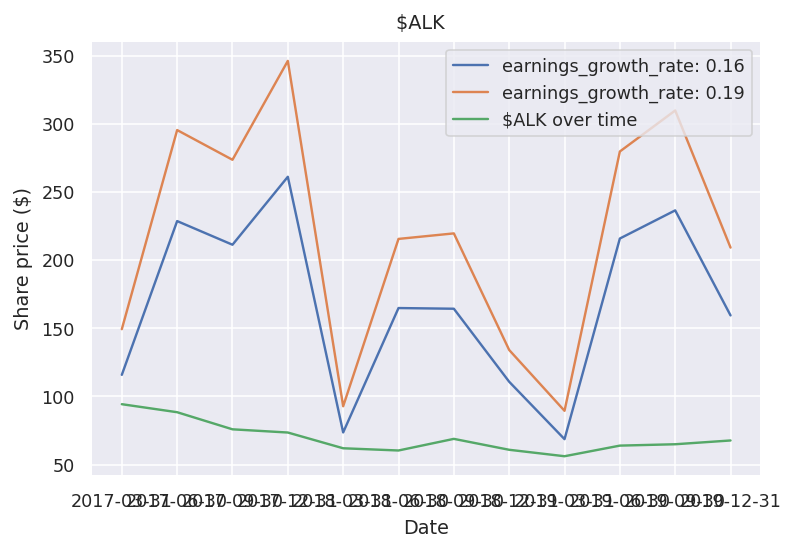

In [221]:
#hide-input

# %%capture%%capture
%matplotlib inline

# import imp 
# !pwd
# helper = imp.new_module('helper')
# exec(open("/main.py").read(), helper.__dict__)

# with fuckit:
  #	can compute DCFs historically on either an 'annual' or 'quarter' basis. if quarter is indicated, total number of DCFS = years * 4
interval = 'quarter'
lookBackPeriod = str(3)
earnings_growth = str(.15)
#some sensitivity analysis: if this is specified, DCFs will be computed for default + (step_increase * interval_number), 
#showing specifically how changing the underlying assumption impacts valuation
step_increase = str(0.1)

#number of steps to take (for step_increase)
steps = str(2)
#the variable to increase each step, those available are: earnings_growth_rate, cap_ex_growth_rate, perpetual_growth_rate, discount_rate
variable = "earnings_growth_rate"
command = str("--t "+subjectCompany+" --i "+interval+"  --y "+lookBackPeriod+" --eg "+earnings_growth+" --steps "+steps+" --s "+step_increase+" --v "+variable+"")

a = main(command)


In [0]:
import pandas as pd
%matplotlib inline
a.show()

# Conclusions and Summary

In [0]:
# print(returned_output.decode("utf-8"))